<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>

## Assessment: Disaster Risk Monitoring Using Satellite Imagery ##
In this notebook, you will utilize what you've learned in this course to complete an assessment. The assessment has been divided into a couple of steps to guide your development. You will be graded based on the performance of your model evaluation. Note that this coding portion does not give partial credit - it shows up as either 0 or 60 points. 
<table border="1" class="dataframe" align='left'>  <thead>    <tr style="text-align: right;">      <th>Step</th>      <th></th>      <th>Points</th>    </tr>  </thead>  <tbody>    <tr>      <td>0. The Problem</td>      <td></td>      <td></td>    </tr>    <tr>      <td>1. Set Up Triton Inference Server</td>      <td></td>      <td></td>    </tr>    <tr>      <td>2. Send Inference Request to Server</td>      <td></td>      <td></td>    </tr>    <tr>      <td>3. Model Performance Evaluation</td>      <td></td>      <td>60</td>    </tr>    <tr>      <td>(BONUS) Performance Analysis</td>      <td></td>      <td></td>    </tr></tbody></table>

### Step 0: The Problem ###
In this course, we used the TAO Toolkit to simplify the development of a segmentation model for flood detection. We were able to easily deploy the segmentation model using the Triton Inference Server. Once deployed, the model needs to be maintained and model performance needs to be monitored over time. In the case where [drift](https://en.wikipedia.org/wiki/Drift_(data_science)) occurs due to changes in the environment, the model starts to have a decay in its predictive power and needs to be re-trained. Below is a depiction of the process. 

<p><img src='images/monitoring.png' width=720></p>

For the assessment we are asking you to generate evaluation metrics for a sample segmentation model, which has been converted to a TensorRT engine (`/dli/task/tao_project/unet/export/sample_resnet18.engine`), on the [Cloud to Street dataset](https://github.com/cloudtostreet/Sen1Floods11). The ability to analyze model performance is critical to a machine learning solution. Your task is to produce inference on the input images and calculate precision, recall, and IoU (intersection over union). 

**Instructions**: <br> 
0.1 Execute the below cell to unzip and load data <br>
0.2 Execute the cell below to set environment variables

In [1]:
# 0.1
# DO NOT CHANGE THIS CELL
# unzip data file
!unzip data/flood_data.zip -d flood_data

Archive:  data/flood_data.zip
  inflating: flood_data/Sen1Floods11_Metadata.geojson  
   creating: flood_data/catalog/
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/Ghana_953791/
  inflating: flood_data/catalog/sen1floods11_hand_labeled_source/Ghana_953791/Ghana_953791.json  
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/Pakistan_210595/
  inflating: flood_data/catalog/sen1floods11_hand_labeled_source/Pakistan_210595/Pakistan_210595.json  
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/USA_198411/
  inflating: flood_data/catalog/sen1floods11_hand_labeled_source/USA_198411/USA_198411.json  
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/Pakistan_740461/
  inflating: flood_data/catalog/sen1floods11_hand_labeled_source/Pakistan_740461/Pakistan_740461.json  
   creating: flood_data/catalog/sen1floods11_hand_labeled_source/Pakistan_401863/
  inflating: 

In [2]:
# 0.2
# DO NOT CHANGE THIS CELL
# set environment variables
import os

%set_env LOCAL_PROJECT_DIR=/dli/task/tao_project
%set_env LOCAL_DATA_DIR=/dli/task/flood_data

os.environ["LOCAL_EXPERIMENT_DIR"]=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), "unet")

env: LOCAL_PROJECT_DIR=/dli/task/tao_project
env: LOCAL_DATA_DIR=/dli/task/flood_data


### Step 1: Set Up Triton Inference Server ###
Next, we will prepare Triton Inference Server. Triton Inference Server has been placed in polling mode. It will serve models within a model repository, which is mounted to the local `models` directory. Below is an example structure of the model repository that contains the segmentation model. For more details on how to work with model repositories and model directory structures in Triton Inference Server, please see the [documentation](https://github.com/triton-inference-server/server/blob/r20.12/docs/model_repository.md). 

```
root@server:/models$ tree
.
├── flood_segmentation_model
│   ├── 1
│   │   └── model.plan
│   └── config.pbtxt
```

**Instructions**: <br>
2.1 Execute the below cell to set up a directory in the model repository and copy the TensorRT engine into the newly created directory. <br>
2.2 Execute the cell below to create the configuration file for the `flood_segmentation_model`. <br>
2.3 Execute the cell below to check the model repository folder structure. <br>
2.4 Execute the cell below to check the status of the `flood_segmentation_model` using the `curl` command. 

In [3]:
# 2.1
# DO NOT CHANGE THIS CELL
# create directory for model
!mkdir -p models/flood_segmentation_model/1

# copy sample_resnet18.engine from previous notebook to the model repository
!cp $LOCAL_EXPERIMENT_DIR/export/sample_resnet18.engine models/flood_segmentation_model/1/model.plan

In [4]:
# 2.2
# DO NOT CHANGE THIS CELL
configuration = """
name: "flood_segmentation_model"
platform: "tensorrt_plan"
max_batch_size: 1
input: [
 {
    name: "input_1"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 512, 512 ]
  }
]
output: {
    name: "softmax_1"
    data_type: TYPE_FP32
    dims: [ 512, 512, 2 ]
  }
"""

with open('models/flood_segmentation_model/config.pbtxt', 'w') as file:
    file.write(configuration)

In [5]:
# 2.3
# DO NOT CHANGE THIS CELL
# show model repository folder structure
!tree -a models

models
└── flood_segmentation_model
    ├── 1
    │   └── model.plan
    └── config.pbtxt

2 directories, 2 files


In [6]:
# 2.4
# DO NOT CHANGE THIS CELL
!sleep 45

# check model status
!curl -v triton:8000/v2/models/flood_segmentation_model

*   Trying 172.18.0.5:8000...
* TCP_NODELAY set
* Connected to triton (172.18.0.5) port 8000 (#0)
> GET /v2/models/flood_segmentation_model HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.68.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Type: application/json
< Content-Length: 224
< 
* Connection #0 to host triton left intact
{"name":"flood_segmentation_model","versions":["1"],"platform":"tensorrt_plan","inputs":[{"name":"input_1","datatype":"FP32","shape":[-1,3,512,512]}],"outputs":[{"name":"softmax_1","datatype":"FP32","shape":[-1,512,512,2]}]}

### Step 3: Send Inference Request to Server ###
The next step is to generate flood mask predictions. With our models deployed, it is now time to send inference requests to our models served on the Triton Inference Server. Triton Inference Server itself does not do anything with your input tensors, it simply feeds them to the model. Same for outputs. Ensuring that the pre-processing operations used for inference are defined identically as they were when the model was trained is key to achieving high accuracy. When we developed the segmentation model, some data pre-processing were done for training. Therefore, we need to perform the same normalization and mean subtraction to produce the final float planar data that the TensorRT engine is looking for. The pre-processing function is: 

<b>y = net scale factor * (x-mean)</b>

where: 
* **x** is the input pixel value. It is an int8 with range [0,255].
* **mean** is `127.5` for all 3 RGB channels. 
* **net-scale-factor** is `1/127.5`, or `0.00784313725490196`. 
* **y** is the corresponding output pixel value. It is a float.

**Instructions**: <br>
3.1 Execute the below cell to load dependencies, set parameters, and instantiate a Triton Client to communicate with the Triton Inference Server at `triton:8000`. <br>
3.2 Modify the `<FIXME>`s only and execute the cell below to define the `preprocessing_image` function. <br>
3.3 Execute the cell below to instantiate a placeholder for our input data and output. <br>
3.4 Modify the `<FIXME>`s only to iteratively pre-process input images, send inference requests, and post-process the inference results for the entire dataset. We will save the mask images. <br>
3.5 Execute the cell below to preview a sample. 

In [7]:
# 3.1
# DO NOT CHANGE THIS CELL
import tritonclient.http as tritonhttpclient
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# set parameters
VERBOSE=False
input_name='input_1'
input_shape=(1, 3, 512, 512)
input_dtype='FP32'
output_name='softmax_1'
model_name='flood_segmentation_model'
url='triton:8000'
model_version='1'

triton_client=tritonhttpclient.InferenceServerClient(url=url, verbose=VERBOSE)

In [8]:
# 3.2
# define pre-process function
def preprocess_image(image): 
    """
    This function returns the pre-processed image as a NumPy array. 
    """
    # load image as a 32-bit floating point array 
    image_ary=np.asarray(image)
    image_ary=image_ary.astype(np.float32)
        
    # pre-processing
    image_ary=(image_ary-127.5)*0.00784313725490196
    
    # the sample_resnet18 segmentation model requires the data to be in BGR format
    BGR=np.empty_like(image_ary)
    BGR[:, :, 0]=image_ary[:, :, 2]
    BGR[:, :, 1]=image_ary[:, :, 1]
    BGR[:, :, 2]=image_ary[:, :, 0]
    image_ary=BGR
    
    # convert array from h, w, c to 1, c, h, w
    image_ary=np.transpose(image_ary, [2, 0, 1])
    image_ary=np.expand_dims(image_ary, axis=0)
    return image_ary

In [9]:
# 3.3
# DO NOT CHANGE THIS CELL
# set inference input and output configurations
inference_input=tritonhttpclient.InferInput(input_name, input_shape, input_dtype)
output=tritonhttpclient.InferRequestedOutput(output_name)

In [10]:
# 3.4
# remove previous inference results if exists
!rm -rf inference_results
!mkdir inference_results

image_dir=os.listdir(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images'))

# iterate through all images
for idx, image_path in enumerate(image_dir): 
    image=Image.open(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', image_path))
    
    # pre-process image
    image_ary=preprocess_image(image)
    
    # send image_ary for inference
    inference_input.set_data_from_numpy(image_ary)
    response=triton_client.infer(model_name, 
                                 model_version=model_version, 
                                 inputs=[inference_input], 
                                 outputs=[output])
    logits=response.as_numpy(output_name)
    
    # post-processing and create mask image from inference output
    mask=np.argmax(logits, axis=3)[0]
    
    # save mask image
    mask_img=Image.fromarray(np.uint8(mask))
    mask_img.save(os.path.join('inference_results', image_path))

Sample: USA_788696.png


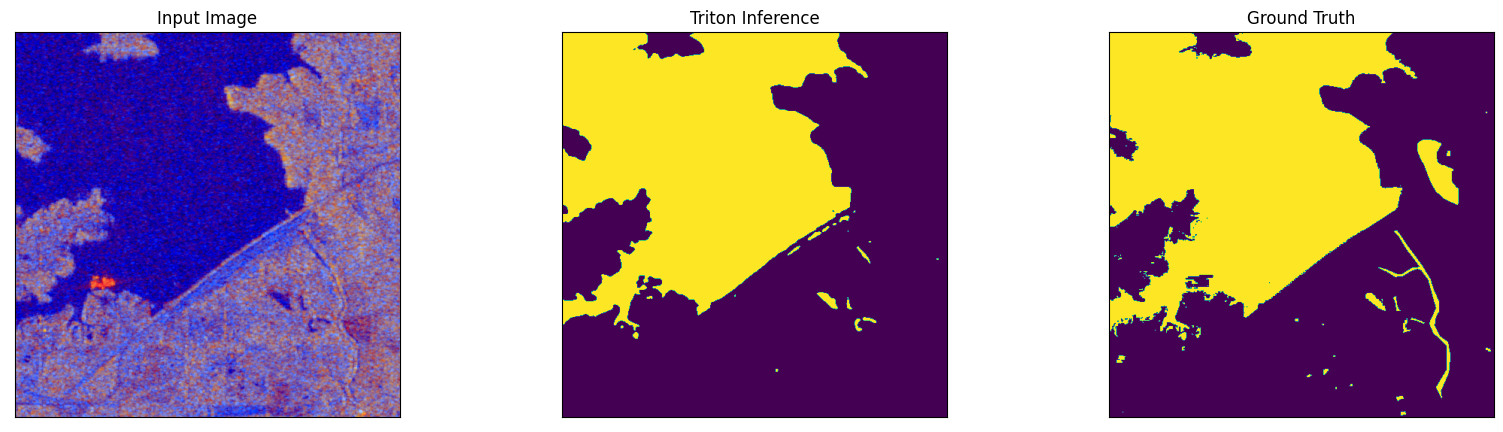

In [11]:
# 3.5
# DO NOT CHANGE THIS CELL
# select random sample
random_choice=random.choice(os.listdir('inference_results'))

# plot input, triton inference, and ground truth
fig, ax=plt.subplots(1, 3, figsize=[20, 5], sharex=True, sharey=True)
ax[0].imshow(plt.imread(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'images', 'all_images', random_choice)))
ax[1].imshow(plt.imread(os.path.join('inference_results', random_choice)))
ax[2].imshow(plt.imread(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'masks', 'all_masks', random_choice)))

# set title
ax[0].set_title('Input Image')
ax[1].set_title('Triton Inference')
ax[2].set_title('Ground Truth')

# remove ticks
ax[0].set_xticks([])
ax[0].set_yticks([])

print('Sample: {}'.format(random_choice))

### Step 4: Model Performance Evaluation ###
The last step is to generate evaluation metrics on the inference performed. As we have learned, **precision**, **recall**, and **IoU** are useful metrics when evaluating a segmentation model. These metrics are derived from the confusion matrix, as shown below: 

<p><img src='images/precision_recall.png' width=720></p>

The first measure is focused on identifying positive cases and is called recall. We define recall as the ability of the model to identify all true positive samples of the dataset. In mathematical terms, recall is the ratio of true positives over true positives plus false negatives. By other means, recall tells us, among all the test samples belonging to the output class, how many of them are identified correctly by the model. The next measure is called precision and is defined as the ability of the model to identify the relevant samples only. It is the ratio of true positives over true positives plus false positives. The last metric is called intersection over union and measures the overlap between the actual and predicted positive, as depicted below: 

<p><img src='images/metrics_visual.png' width=720></p>

**Instructions**: <br>
4.1 Replace the `<FIXME>`s with either `==` (equal) or `!=` (not equal) as appropriate, and execute the below cell to define the `calc_confusion_matrix` function. <br>
4.2 Execute the cell below to calculate precision, recall, and IoU (intersection over union) for class `1`, which indicates `flood`. <br>
4.3 Execute the cell below to mark your answer for grading. 

**Notes**: <br>
Only the IoU will be graded. To help you complete the assessment, we have provided the precision and recall. 

In [ ]:
# 4.1
# define calc_confusion_matrix function
def calc_confusion_matrix(inference, ground_truth, class_id): 
    # calculate true positive, false positive, false negative, and true positive
    true_negative=((inference!=class_id) & (ground_truth!=class_id)).sum()
    false_positive=((inference==class_id) & (ground_truth!=class_id)).sum()
    false_negative=((inference!=class_id) & (ground_truth==class_id)).sum()
    true_positive=((inference<<<<FIXME>>>>class_id) & (ground_truth<<<<FIXME>>>>class_id)).sum()
    return true_negative, false_positive, false_negative, true_positive

In [ ]:
# 4.2
# DO NOT CHANAGE THIS CELL
# set target class and create lists to hold tn, fp, fn, and tp
target_class=1
tns=[]
fps=[]
fns=[]
tps=[]

for each_inference in os.listdir('inference_results'): 
    if each_inference.split('.')[-1]=='png': 
        inference=plt.imread(os.path.join('inference_results', each_inference))*255
        ground_truth=plt.imread(os.path.join(os.getenv('LOCAL_DATA_DIR'), 'masks', 'all_masks', each_inference))

        tn, fp, fn, tp=calc_confusion_matrix(inference, ground_truth, target_class)
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        tns.append(tn)
            
recall=sum(tps)/(sum(tps)+sum(fns))
precision=sum(tps)/(sum(tps)+sum(fps))
iou=sum(tps)/(sum(tps)+sum(fps)+sum(fns))

print('Recall is {} when it should be 0.6649179565283793. '.format(recall))
print('Precision is {} when it should be 0.7669037257648811. '.format(precision))
print('IoU is {}. '.format(iou))

In [ ]:
# 4.3
# DO NOT CHANGE BELOW
with open('/dli/task/my_assessment/answer.txt', 'w') as f: 
    f.write(str(round(iou, 2)))

### Grade Your Code ###
If you have completed model evaluation successfully, save changes to the notebook and revisit the webpage where you launched this interactive environment. Click on the "**ASSESS TASK**" button as shown in the screenshot below. Doing so will give you credit for this part of the lab that counts towards earning a certificate of competency for the entire course.
<p><img src='images/credit.png' width=720></p>

### BONUS. Performance Evaluation ###
Below we have included some sample procedures to calculate the performance metrics based on image groups - this is intended to demonstrate potential weaknesses of the model that could warrant further fine-tuning of the model. There are a number of techniques to improve model performance, including adding relevant training data. 

**Instructions**: <br>
B.1 Execute the below cell to create a DataFrame with the appropriate data. <br>
B.2 Execute the cell below to calculate IoU for each image group and visualize the results for comparison. 

In [ ]:
# DO NOT CHANGE THIS CELL
import pandas as pd

# create DataFrame
df=pd.DataFrame({'image': os.listdir('inference_results'), 
                 'tp': tps, 
                 'fp': fps, 
                 'fn': fns, 
                 'tn': tns})

# create image_group, union, and intersect columns
df['image_group']=df['image'].str.split('_').str[0]
df['union']=df['tp']+df['fp']+df['fn']
df['intersect']=df['tp']
df.head()

In [ ]:
# B.2
# group by image_group and calculate iou
df_grouped=df.groupby('image_group')[['intersect', 'union']].sum()
df_grouped['iou']=df_grouped['intersect']/df_grouped['union']

# visualize results
df_grouped.sort_values(by='iou', ascending=False)['iou'].plot(kind='bar', figsize=(10, 5))
plt.title('IoU by Image Group')
plt.xlabel('Image Group')
plt.ylabel('IoU')
plt.show()

<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>